In [1]:
# Import packages used in all code
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.utils import resample
from random import seed
from random import randint
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from numpy import argmax
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import os
import seaborn as sns
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn.utils import shuffle
from sklearn.base import clone

##############################################################################################
#resample_features
#resamples data with Pb violations to match complient data 
##############################################################################################


def resample_features(features, labels, multiplier):
    zeros = np.where(labels == 0)
    ones = np.where(labels == 1)
    features_zero = features[zeros]
    features_one = features[ones]
    features_one = resample(features_one, replace=True,n_samples=len(features_zero)*multiplier, 
                            random_state=100)
    features_zero = np.insert(features_zero, 0, 0, axis=1)
    features_one = np.insert(features_one, 0, 1, axis=1)
    features_final = np.append(features_zero, features_one, axis=0)
    return features_final

##############################################################################################
#Random number generator
#returns a randomly generated array with the same length as the train labels by using the test 
#labels to generate a prob distribution
##############################################################################################


def random_number_gen(train_labels, test_labels):
    seed(2)
    prob_Pb = round(sum(train_labels)/len(train_labels),2)*100
    random_gen=[]
    for i in range(test_labels.shape[0]):
        random_num = randint(0, 100)
        if random_num<=prob_Pb:
            result = 1
        else:
            result = 0
        random_gen.append(result)
    return random_gen

##############################################################################################
#Drop column score
#calculates OOB score or ROC AUC score as features are dropped out of the model
##############################################################################################
def drop_col_feat_imp(model, X_train, y_train, X_test, y_test, mode):
    model_clone = model
    importances = []
    if mode == 'OOB':
        model_clone.fit(X_train, y_train)
        benchmark_score = model_clone.oob_score_
        for col in range(X_train.shape[1]):
            X_train_drop = np.delete(X_train, col, 1)
            X_test_drop = np.delete(X_test, col, 1)
            model_clone.fit(X_train_drop, y_train)
            drop_score = model_clone.oob_score_
            importances.append(benchmark_score - drop_score)

        importances_df = importances
    
    elif mode == 'AUC':
        model_clone.fit(X_train, y_train)
        predicted_proba = model_clone.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, predicted_proba[:,1])
        roc_auc = auc(fpr, tpr)
        benchmark_score = roc_auc
        for col in range(X_train.shape[1]):
            X_train_drop = np.delete(X_train, col, 1)
            X_test_drop = np.delete(X_test, col, 1)
            model_clone.fit(X_train_drop, y_train)
            predicted_proba = model_clone.predict_proba(X_test_drop)
            fpr, tpr, thresholds = roc_curve(y_test, predicted_proba[:,1])
            roc_auc = auc(fpr, tpr)
            drop_score = roc_auc
            importances.append(benchmark_score - drop_score)

        importances_df = importances
    
    return importances_df, benchmark_score

##############################################################################################
#Preprocess data
#preprocessess data for use in random forest by transformin categorical data and getting rid of text
#option to normalize and to chose Pb violation threshold 
#normalize if normalize = True. Threshold may be 5, 10 or 15
##############################################################################################
def preprocess_data(df, Pb_threshold, normalize):
    #Obtain features and labels from imported file
    if Pb_threshold == 5:
        labels = df['ProbCategory_5_ppb']
    elif Pb_threshold == 10:
        labels = df['ProbCategory_10_ppb']
    elif Pb_threshold == 15:
        labels = df['ProbCategory_15_ppb']
    features = df
    #drop unnecessary columns
    features.drop('ProbCategory_15_ppb', inplace = True, axis = 1)
    features.drop('ProbCategory_10_ppb', inplace = True, axis = 1)
    features.drop('ProbCategory_5_ppb', inplace = True, axis = 1)
    features.drop('RESULT', inplace = True, axis = 1)
    features.drop('DISINFECTANT', inplace = True, axis = 1)
    features.drop('notes about the water quality parameters', inplace = True, axis = 1)
    features.drop('Counties Served', inplace = True, axis = 1)
    features.drop('Cities Served', inplace = True, axis = 1)
    features.drop('County', inplace = True, axis = 1)
    features.drop(features.iloc[:, 0:5], inplace = True, axis = 1) 

    # use Imputer to fill in missing feature data with the mean of the column
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    missing_values= imputer.fit(features)
    features = imputer.transform(features)

    #normalize data (optional)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(features)
        features = x_scaled
    
    return features, labels


In [16]:
##############################################################################################
#Random forest model - predicts whether Pb leaching is likely to occur in a school based on 
#water quality and socio-economic data
##############################################################################################

#read excel file with features (inputs) and labels (outputs)
Pb_data = pd.read_excel('MA dataset.xlsx')

#preprocess data
features, labels = preprocess_data(Pb_data, 15, True)
# Using Skicit-learn to split data into training and testing sets

train_features, test_features, train_labels, test_labels= train_test_split(features, 
    labels, test_size = 0.3, random_state = 42)

train_features = resample_features(train_features, train_labels,2)
train_labels = train_features[:,0]
train_features = np.delete(train_features, 0, axis=1)

test_features = resample_features(test_features, test_labels,2)
test_labels = test_features[:,0]
test_features = np.delete(test_features, 0, axis=1)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

# Implement random forest on train data
rf = RandomForestClassifier(n_estimators = 500, random_state = 42, criterion='entropy', oob_score=True, max_depth=12)
#rf = RandomForestClassifier()
rf.fit(train_features, train_labels)
threshold = 0.5
predicted_proba = rf.predict_proba(test_features)
#predict using the test data
#rf_prediction = rf.predict(test_features)
rf_prediction = (predicted_proba [:,1] >= threshold).astype('int')



Training Features Shape: (1023, 65)
Training Labels Shape: (1023,)
Testing Features Shape: (462, 65)
Testing Labels Shape: (462,)


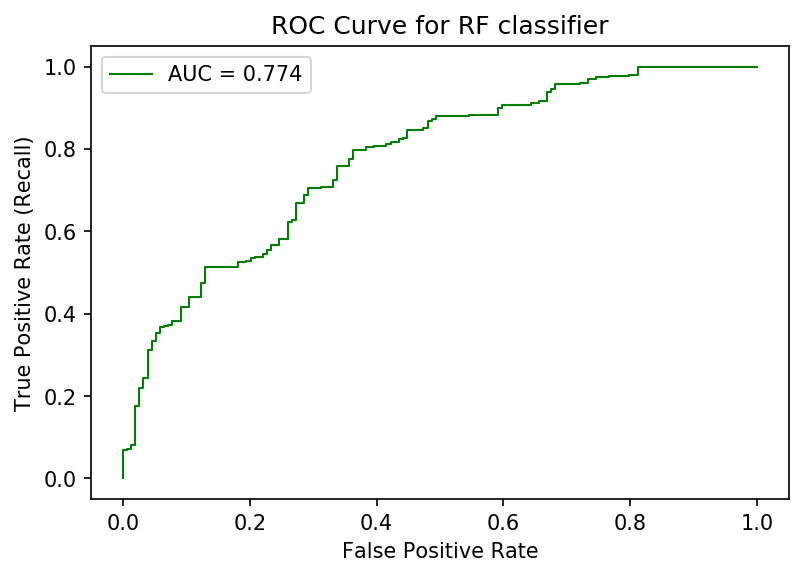

Best Threshold=0.280006, F-Score=0.833


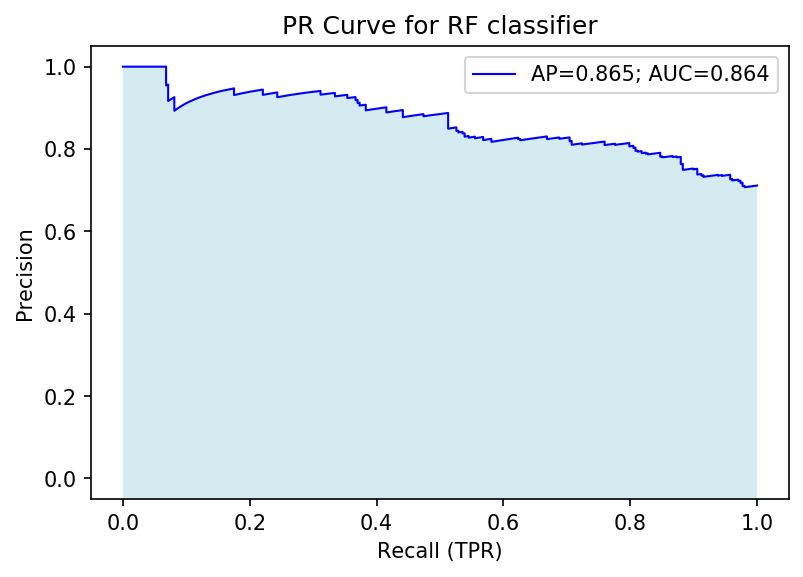

In [17]:
#plot ROC curve
# get false and true positive rates
fpr, tpr, thresholds = roc_curve(test_labels, predicted_proba[:,1])
# get area under the curve
roc_auc = auc(fpr, tpr)
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

#plot precision-recall curve

# get precision and recall values
precision, recall, thresholds = precision_recall_curve(test_labels, predicted_proba[:,1])
# average precision score
avg_precision = average_precision_score(test_labels, predicted_proba[:,1])
# precision auc
pr_auc = auc(recall, precision)
#chose best threshold based on f score
zeros = np.where(precision == 0)
precision = np.delete(precision, zeros)
recall = np.delete(recall, zeros)
thresholds= np.delete(thresholds, zeros)
fscore = (2 * precision * recall) / (precision + recall)
fscore = fscore[np.logical_not(np.isnan(fscore))]
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot
plt.figure(dpi=150)
plt.plot(recall, precision, lw=1, color='blue', label=f'AP={avg_precision:.3f}; AUC={pr_auc:.3f}')
#plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)
plt.title('PR Curve for RF classifier')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

In [18]:
##############################################################################################
#Data analysis
##############################################################################################
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
rfc_cv_score = cross_val_score(rf, features, labels, cv=cv, scoring='roc_auc')

#OOB score
rf_clone = clone(rf)
oob_features, oob_labels = shuffle(features,labels)
rf_clone.fit(oob_features, oob_labels)
OOB_score = rf_clone.oob_score_

#calculate random predictions using a random number generator to compare to RF data
random_prediction = random_number_gen(train_labels, test_labels)

print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
print('\n')

print("=== Out of Bag Error ===")
print("OOB Score - Random Forest: ", OOB_score)
print('\n')

print("=== Data ===")
print('1:', sum(test_labels),'0:',len(test_labels) - sum(test_labels))
print('\n')

print("=== Confusion Matrix - Random Forest ===")
print(confusion_matrix(test_labels, rf_prediction, labels=[1,0]))
print('\n')

print("=== Confusion Matrix - Random Number Generator ===")
print(confusion_matrix(test_labels, random_prediction, labels=[1,0]))
print('\n')

print("=== Classification Report - Random Forest ===")
print(classification_report(test_labels, rf_prediction, labels=[1,0]))
print('\n')

print("=== Classification Report - Random Number Generator ===")
print(classification_report(test_labels, random_prediction, labels=[1,0]))
print('\n')


=== All AUC Scores ===
[0.77985348 0.76998454 0.73021812 0.72009497 0.78423567 0.73996644
 0.77775558 0.74731935 0.72673993 0.75142359]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7527591658540188


=== Out of Bag Error ===
OOB Score - Random Forest:  0.7295434969853575


=== Data ===
1: 308.0 0: 154.0


=== Confusion Matrix - Random Forest ===
[[255  53]
 [ 68  86]]


=== Confusion Matrix - Random Number Generator ===
[[213  95]
 [107  47]]


=== Classification Report - Random Forest ===
              precision    recall  f1-score   support

           1       0.79      0.83      0.81       308
           0       0.62      0.56      0.59       154

    accuracy                           0.74       462
   macro avg       0.70      0.69      0.70       462
weighted avg       0.73      0.74      0.73       462



=== Classification Report - Random Number Generator ===
              precision    recall  f1-score   support

           1       0.67      0.69      0.68       

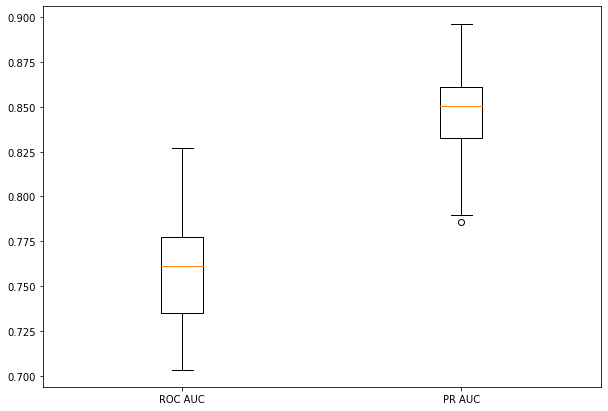

In [19]:
##############################################################################################
#ROC-AUC and PR-AUC for various splits
#obtains the ROC-AUC and PR-AUC values and charts for 100 runs of RF
##############################################################################################

ROCs = []
PRs = []
for state in range(500,5000,50):
    
    train_features, test_features, train_labels, test_labels= train_test_split(features, 
        labels, test_size = 0.2, random_state = state)

    train_features = resample_features(train_features, train_labels,2)
    train_labels = train_features[:,0]
    train_features = np.delete(train_features, 0, axis=1)

    test_features = resample_features(test_features, test_labels,2)
    test_labels = test_features[:,0]
    test_features = np.delete(test_features, 0, axis=1)
    
    rf_optimum = RandomForestClassifier()
    
    rf_optimum.fit(train_features, train_labels)
    probas = rf_optimum.predict_proba(test_features)
    
    #ROC curve
    # get false and true positive rates
    fpr, tpr, thresholds = roc_curve(test_labels, probas[:,1])
    # get area under the curve
    roc_auc = auc(fpr, tpr)
    ROCs.append(roc_auc)
    
    #PR curve
    precision, recall, thresholds = precision_recall_curve(test_labels, probas[:,1])
    # average precision score
    avg_precision = average_precision_score(test_labels, probas[:,1])
    # precision auc
    pr_auc = auc(recall, precision)
    PRs.append(pr_auc)
    
fig = plt.figure(figsize =(10, 7)) 
  
# Creating plot 
ROC_PR_data = [ROCs, PRs]
plt.boxplot(ROC_PR_data, labels = ['ROC AUC', 'PR AUC']) 
  
# show plot 
plt.show() 

Feature ranking:


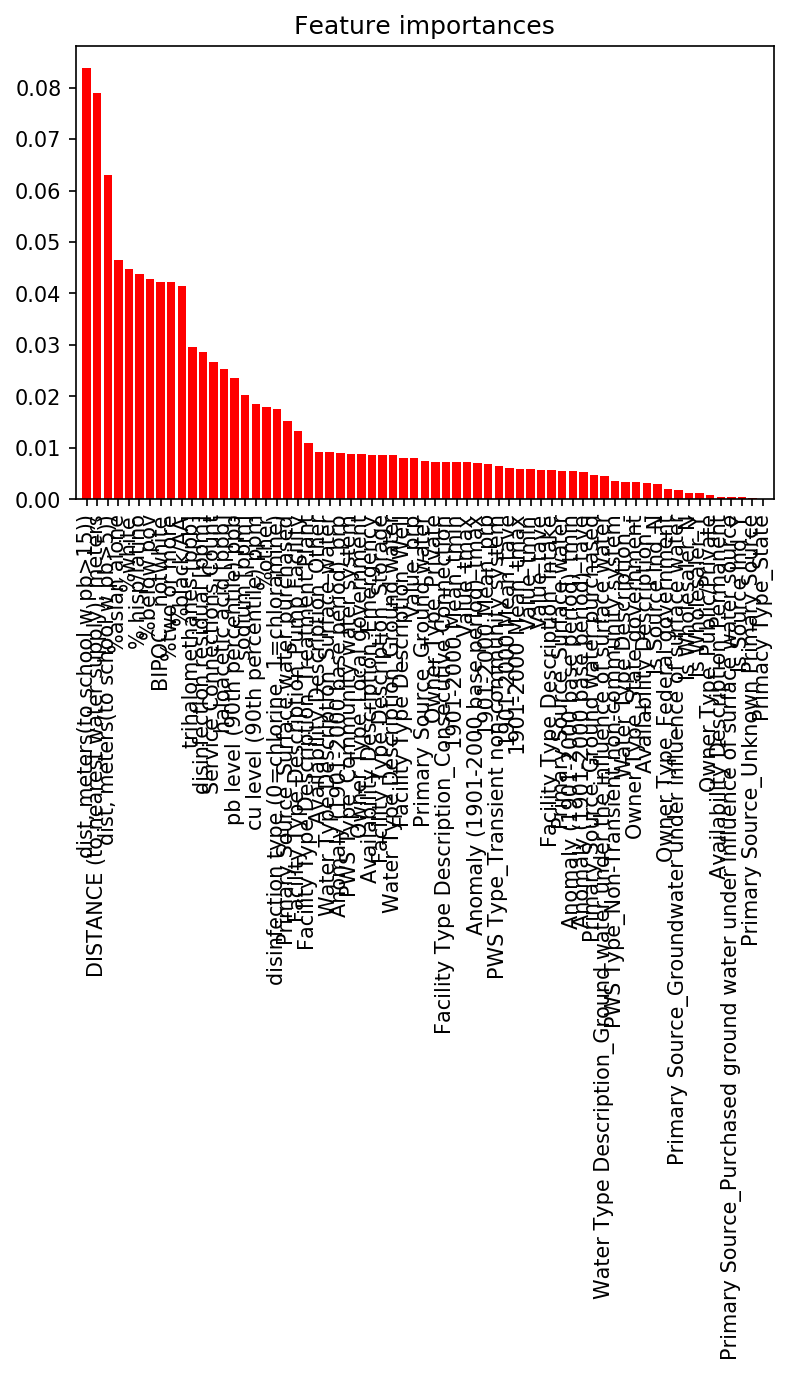

In [20]:
##############################################################################################
#Feature importance analysis - Gini index
#
##############################################################################################
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_head = Pb_data.columns
feature_head= feature_head[indices]
# Print the feature ranking
print("Feature ranking:")

# Plot the impurity-based feature importances of the forest
plt.figure(dpi=150)
plt.title("Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
        color="r")
plt.xticks(range(train_features.shape[1]), feature_head, rotation='vertical')
plt.xlim([-1, train_features.shape[1]])
plt.show()

In [30]:
##############################################################################################
#Feature importance analysis - feature type
#
##############################################################################################

names = ['water_social', 'social_spatial', 'spatial_water', 'all']
AUC_variables = []
for sheetname in names:
#read excel file with features (inputs) and labels (outputs)
    Pb_data_s = pd.read_excel('MA dataset.xlsx', sheet_name = sheetname )
    #Obtain features and labels from imported file
    labels_s = Pb_data_s['ProbCategory_5_ppb']
    features_s = Pb_data_s
    features_s.drop('ProbCategory_15_ppb', inplace = True, axis = 1)
    features_s.drop('ProbCategory_10_ppb', inplace = True, axis = 1)
    features_s.drop('ProbCategory_5_ppb', inplace = True, axis = 1)
    features_s.drop('RESULT', inplace = True, axis = 1)
    features_s.drop('DISINFECTANT', inplace = True, axis = 1)
    features_s.drop('notes about the water quality parameters', inplace = True, axis = 1)
    features_s.drop('Counties Served', inplace = True, axis = 1)
    features_s.drop('Cities Served', inplace = True, axis = 1)
    features_s.drop('County', inplace = True, axis = 1)
    
    features_s.drop(Pb_data_s.iloc[:, 0:4], inplace = True, axis = 1) 

    # use Imputer to fill in missing feature data with the mean of the column
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    missing_values= imputer.fit(features_s)
    features_s = imputer.transform(features_s)
    
    random_states = range(20,200,20)
    AUCs = []
    for r in random_states:
        # Using Skicit-learn to split data into training and testing sets
        train_features_s, test_features_s, train_labels_s, test_labels_s= train_test_split(features_s, 
            labels_s, test_size = 0.3, random_state = r)

        #resample
        train_features_s = resample_features(train_features_s, train_labels_s,2)
        train_labels_s = train_features_s[:,0]
        train_features_s = np.delete(train_features_s, 0, axis=1)

        test_features_s = resample_features(test_features_s, test_labels_s,2)
        test_labels_s = test_features_s[:,0]
        test_features_s = np.delete(test_features_s, 0, axis=1)

        rf = RandomForestClassifier()
        rf.fit(train_features_s, train_labels_s)
        predicted_proba_s = rf.predict_proba(test_features_s)
        rf_roc_auc_1 = metrics.roc_auc_score(test_labels_s, predicted_proba_s[:,1])
        AUCs.append(rf_roc_auc_1)

    print(sheetname, ':', np.average(AUCs), np.std(AUCs))
    AUC_variables.append(AUCs)





water_social : 0.7448544829313337 0.03075904007525856
social_spatial : 0.7383199493818848 0.03108628889146997
spatial_water : 0.7616782224850607 0.01663063925465207
all : 0.7633706218796581 0.025047575542911746


In [32]:
##############################################################################################
#Machine learning model comparison
#
##############################################################################################

import os
import seaborn as sns
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image
from pydotplus import graph_from_dot_data


df = Pb_data

x_train = train_features
y_train = train_labels
x_test = test_features
y_test = test_labels


# LOGISTIC REGRESSION
# Instantiate, fit and obtain accuracy score
logit_model = LogisticRegression(max_iter=1000)
logit_model = logit_model.fit(x_train, y_train)
logit_model.score(x_train, y_train)

# Examine the coefficients
#pd.DataFrame(zip(x_train.columns, np.transpose(logit_model.coef_)))

# Predictions on the test dataset
predicted = pd.DataFrame(logit_model.predict(x_test))

# Probabilities on the test dataset
probs = pd.DataFrame(logit_model.predict_proba(x_test))

# Store metrics
logit_accuracy = metrics.accuracy_score(y_test, predicted)
logit_roc_auc = metrics.roc_auc_score(y_test, probs[1])
logit_confus_matrix = metrics.confusion_matrix(y_test, predicted)
logit_classification_report = metrics.classification_report(y_test, predicted)
logit_precision = metrics.precision_score(y_test, predicted, pos_label=1)
logit_recall = metrics.recall_score(y_test, predicted, pos_label=1)
logit_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

print('Logistic confusion matrix:')
print(logit_confus_matrix)

# Evaluate the model using 10-fold cross-validation
logit_cv_scores = cross_val_score(LogisticRegression(), x_test, y_test, scoring='roc_auc', cv=10)
logit_cv_mean = np.mean(logit_cv_scores)

# DECISION TREE (pruned to depth of 3)
# TODO optimise depth

# Instantiate with a max depth of 3
tree_model = tree.DecisionTreeClassifier(max_depth=3)
# Fit a decision tree
tree_model = tree_model.fit(x_train, y_train)
# Training accuracy
tree_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(tree_model.predict(x_test))
probs = pd.DataFrame(tree_model.predict_proba(x_test))

# Store metrics
tree_accuracy = metrics.accuracy_score(y_test, predicted)
tree_roc_auc = metrics.roc_auc_score(y_test, probs[1])
tree_confus_matrix = metrics.confusion_matrix(y_test, predicted)
tree_classification_report = metrics.classification_report(y_test, predicted)
tree_precision = metrics.precision_score(y_test, predicted, pos_label=1)
tree_recall = metrics.recall_score(y_test, predicted, pos_label=1)
tree_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

print('Tree confusion matrix:')
print(tree_confus_matrix)

# Evaluate the model using 10-fold cross-validation
tree_cv_scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=3),
                                x_test, y_test, scoring='roc_auc', cv=10)
tree_cv_mean = np.mean(tree_cv_scores)


# RANDOM FOREST
# Instantiate
rf = RandomForestClassifier()
# Fit
rf_model = rf.fit(x_train, y_train)
# Training accuracy
rf_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(rf_model.predict(x_test))
probs = pd.DataFrame(rf_model.predict_proba(x_test))

# Store metrics
rf_accuracy = metrics.accuracy_score(y_test, predicted)
rf_roc_auc = metrics.roc_auc_score(y_test, probs[1])
rf_confus_matrix = metrics.confusion_matrix(y_test, predicted)
rf_classification_report = metrics.classification_report(y_test, predicted)
rf_precision = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

print('Random forest confusion matrix:')
print(rf_confus_matrix)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test, y_test, scoring='roc_auc', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)

# SUPPORT VECTOR MACHINE
# Instantiate
svm_model = SVC(probability=True)
# Fit
svm_model = svm_model.fit(x_train, y_train)
# Accuracy
svm_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(svm_model.predict(x_test))
probs = pd.DataFrame(svm_model.predict_proba(x_test))

# Store metrics
svm_accuracy = metrics.accuracy_score(y_test, predicted)
svm_roc_auc = metrics.roc_auc_score(y_test, probs[1])
svm_confus_matrix = metrics.confusion_matrix(y_test, predicted)
svm_classification_report = metrics.classification_report(y_test, predicted)
svm_precision = metrics.precision_score(y_test, predicted, pos_label=1)
svm_recall = metrics.recall_score(y_test, predicted, pos_label=1)
svm_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

print('SVM confusion matrix:')
print(svm_confus_matrix)

# Evaluate the model using 10-fold cross-validation
svm_cv_scores = cross_val_score(SVC(probability=True), x_test, y_test, scoring='roc_auc', cv=10)
svm_cv_mean = np.mean(svm_cv_scores)

# KNN
# Instantiate learning model (k = 3)
knn_model = KNeighborsClassifier(n_neighbors=3)
# Fit the model
knn_model.fit(x_train, y_train)
# Accuracy
knn_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(knn_model.predict(x_test))
probs = pd.DataFrame(knn_model.predict_proba(x_test))

# Store metrics
knn_accuracy = metrics.accuracy_score(y_test, predicted)
knn_roc_auc = metrics.roc_auc_score(y_test, probs[1])
knn_confus_matrix = metrics.confusion_matrix(y_test, predicted)
knn_classification_report = metrics.classification_report(y_test, predicted)
knn_precision = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

print('knn confusion matrix')
print(knn_confus_matrix)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='roc_auc', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)

# TWO CLASS BAYES
# Instantiate
bayes_model = GaussianNB()
# Fit the model
bayes_model.fit(x_train, y_train)
# Accuracy
bayes_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(bayes_model.predict(x_test))
probs = pd.DataFrame(bayes_model.predict_proba(x_test))

# Store metrics
bayes_accuracy = metrics.accuracy_score(y_test, predicted)
bayes_roc_auc = metrics.roc_auc_score(y_test, probs[1])
bayes_confus_matrix = metrics.confusion_matrix(y_test, predicted)
bayes_classification_report = metrics.classification_report(y_test, predicted)
bayes_precision = metrics.precision_score(y_test, predicted, pos_label=1)
bayes_recall = metrics.recall_score(y_test, predicted, pos_label=1)
bayes_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

print('bayes matrix')
print(bayes_confus_matrix)

# Evaluate the model using 10-fold cross-validation
bayes_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='roc_auc', cv=10)
bayes_cv_mean = np.mean(bayes_cv_scores)

# EVALUATE
# Model comparison
models = pd.DataFrame({
    'Model'    : ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'kNN', 'Bayes'],
    'Accuracy' : [logit_accuracy, tree_accuracy, rf_accuracy, svm_accuracy, knn_accuracy, bayes_accuracy],
    'Precision': [logit_precision, tree_precision, rf_precision, svm_precision, knn_precision, bayes_precision],
    'recall'   : [logit_recall, tree_recall, rf_recall, svm_recall, knn_recall, bayes_recall],
    'F1'       : [logit_f1, tree_f1, rf_f1, svm_f1, knn_f1, bayes_f1],
    'cv_precision' : [logit_cv_mean, tree_cv_mean, rf_cv_mean, svm_cv_mean, knn_cv_mean, bayes_cv_mean],
    'ROC AUC'       : [logit_roc_auc, tree_roc_auc, rf_roc_auc, svm_roc_auc, knn_roc_auc, bayes_roc_auc]
    })
models.sort_values(by='Precision', ascending=False)




Logistic confusion matrix:
[[ 31  53]
 [ 16 152]]
Tree confusion matrix:
[[ 30  54]
 [ 15 153]]
Random forest confusion matrix:
[[ 55  29]
 [ 39 129]]
SVM confusion matrix:
[[ 26  58]
 [ 11 157]]
knn confusion matrix
[[ 43  41]
 [ 50 118]]
bayes matrix
[[ 75   9]
 [142  26]]


,Model,Accuracy,Precision,recall,F1,cv_precision,ROC AUC
2,Random Forest,0.730159,0.816456,0.767857,0.791411,0.849469,0.767467
5,Bayes,0.400794,0.742857,0.154762,0.256158,0.721671,0.634921
4,kNN,0.638889,0.742138,0.702381,0.721713,0.721671,0.671414
0,Logistic Regression,0.726190,0.741463,0.904762,0.815013,0.674632,0.656746
1,Decision Tree,0.726190,0.739130,0.910714,0.816000,0.707475,0.633149
3,SVM,0.726190,0.730233,0.934524,0.819843,0.719894,0.701601
